# Check predictions with a trained model

In [1]:
# !pip uninstall -y pytorch-ignite
# !pip install --upgrade git+https://github.com/pytorch/ignite.git
# !pip install git+https://github.com/qubvel/ttach.git

In [2]:
import sys
sys.path.insert(0, "../code")

In [3]:
data_path = "../input/train_tiles/"
csv_path = "../input/train_tiles/tile_stats.csv"

In [4]:
from dataflow.datasets import get_trainval_datasets, read_img_in_db_with_mask

In [5]:
train_folds = [0, 1, 3]
val_folds = [2, ]

train_ds, val_ds = get_trainval_datasets(data_path, csv_path, train_folds=train_folds, val_folds=val_folds, read_img_mask_fn=read_img_in_db_with_mask)

In [6]:
from dataflow.vis import make_grid

import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [7]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

mean = [-17.398721187929123, -10.020421713800838, -12.10841437771272]
std = [6.290316422115964, 5.776936185931195, 5.795418280085563]
max_value = 1.0

val_transforms = A.Compose([
    A.Normalize(mean=mean, std=std, max_pixel_value=max_value),
    ToTensorV2()
])

In [8]:
device = 'cpu'
non_blocking = False

Load trained model

In [9]:
import os
os.environ['MLFLOW_TRACKING_URI']="../output/mlruns"

In [10]:
from segmentation_models_pytorch import FPN

model = FPN(encoder_name='se_resnext50_32x4d', classes=2, encoder_weights=None)
run_uuid = "5230c20f609646cb9870a211036ea5cb"
weights_filename = "best_model_67_val_miou_bg=0.7574240313552584.pth"

In [11]:
import torch
from utils.commons import get_artifact_path

sd = torch.load(get_artifact_path(run_uuid, weights_filename))
sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
model.load_state_dict(sd)

<All keys matched successfully>

In [12]:
model = model.to(device)
model.eval();

Load another trained model

In [13]:
# from torchvision.models.segmentation import deeplabv3_resnet101
# model2 = deeplabv3_resnet101(num_classes=num_classes)
# run_uuid = "a3a88249f6be4941a9e4999a1dbd0668"
# weights_filename = "best_model_4_val_miou_bg=0.7337625.pth"
# model2.load_state_dict(torch.load(get_artifact_path(run_uuid, weights_filename)))

In [14]:
# from segmentation_models_pytorch import Unet


# model2 = Unet(encoder_name='resnet50', classes=2)
# run_uuid = "48bddd1fcabb41acaedce035e16247cb"
# weights_filename = "best_model_1_val_miou_bg=0.7517839.pth"

# model_weights_filepath = get_artifact_path(run_uuid, weights_filename)
# state_dict = torch.load(model_weights_filepath)
# model2.load_state_dict(state_dict['model'])

In [15]:
from segmentation_models_pytorch import FPN

model2 = FPN(encoder_name='se_resnext50_32x4d', classes=2, encoder_weights=None)
run_uuid = "30187583292246f6999d499642372da9"
weights_filename = "best_model_43_val_miou_bg=0.7530081542328186.pth"

In [16]:
import torch
from utils.commons import get_artifact_path

sd = torch.load(get_artifact_path(run_uuid, weights_filename))
sd = {k.replace("module.", "", 1): v for k, v in sd.items()}
model2.load_state_dict(sd)

<All keys matched successfully>

In [17]:
model2 = model2.to(device)
model2.eval();

Compute metrics on batch

In [17]:
from dataflow.dataloaders import get_train_val_loaders, get_train_sampler

In [18]:
train_loader, val_loader, _ = get_train_val_loaders(train_ds, val_ds, 
                                                    train_transforms=val_transforms, val_transforms=val_transforms, 
                                                    batch_size=4, val_batch_size=4, num_workers=2, pin_memory=("cuda" in device))

In [19]:
from dataflow.transforms import inference_prepare_batch_f32 as prepare_batch

In [20]:
with_tta = True


import ttach as tta

# transforms = tta.aliases.d4_transform()

transforms = tta.Compose([
    tta.Rotate90(angles=[90, -90, 180]),
])

len(transforms)

4

In [22]:
def eval_update_function(engine, batch):
    with torch.no_grad():
        x, y, meta = prepare_batch(batch, device=device, non_blocking=non_blocking)

        if not with_tta:
            y_pred = model(x)    
        else:
            y_preds = []
            for t in transforms:
                t_x = t.augment_image(x)
                t_y_pred = model(t_x)
                y_pred = t.deaugment_mask(t_y_pred)
                y_preds.append(y_pred)

            y_preds = torch.stack(y_preds, dim=0)
            y_pred = torch.mean(y_preds, dim=0)

        return {
            "y_pred": y_pred,
            "y": y,
            "meta": meta
        }

In [24]:
from ignite.metrics import IoU, ConfusionMatrix, mIoU, Fbeta
from ignite.metrics.confusion_matrix import cmAccuracy, cmPrecision, cmRecall


def output_transform(output):
    return output['y_pred'], output['y']


num_classes = 2
cm_metric = ConfusionMatrix(num_classes=num_classes, output_transform=output_transform)
pr = cmPrecision(cm_metric, average=False)
re = cmRecall(cm_metric, average=False)

val_metrics = {
    "IoU": IoU(cm_metric),
    "mIoU_bg": mIoU(cm_metric),
    "Accuracy": cmAccuracy(cm_metric),
    "Precision": pr,
    "Recall": re,
    "F1": Fbeta(beta=1.0, output_transform=output_transform)
}


In [25]:
from ignite.engine import Engine, Events


evaluator = Engine(eval_update_function)

for name, metric in val_metrics.items():
    metric.attach(evaluator, name)


In [25]:
val_loader_iter = iter(val_loader)

In [26]:
batch = next(val_loader_iter)

In [27]:
with_tta = False
state = evaluator.run([batch, ])
state.metrics

{'IoU': tensor([0.9953, 0.0000], dtype=torch.float64),
 'mIoU_bg': 0.4976649284362793,
 'Accuracy': 0.9953298568725586,
 'Precision': tensor([1., 0.], dtype=torch.float64),
 'Recall': tensor([0.9953, 0.0000], dtype=torch.float64),
 'F1': 0.49882973155757754}

In [57]:
with_tta = True
state = evaluator.run([batch, ])
state.metrics

{'IoU': tensor([0.9928, 0.4109], dtype=torch.float64),
 'mIoU_bg': 0.7018557127771865,
 'Accuracy': 0.9928464889526367,
 'Precision': tensor([0.9961, 0.6008], dtype=torch.float64),
 'Recall': tensor([0.9967, 0.5652], dtype=torch.float64)}

Visualization

In [18]:
from pathlib import Path
from dataflow.vis import render_image, render_mask, render_datapoint, default_palette

from ignite.metrics.confusion_matrix import ConfusionMatrix, IoU

preds_palette = (0, 0, 0, 255, 255, 0)

num_classes = 2
cm = ConfusionMatrix(num_classes=num_classes)
iou_metric = IoU(cm, ignore_index=0)


def to_numpy(y):
    return y[0, :, :].byte().cpu().numpy()


def display_preds(y_preds, y, image):
    _im = render_image(image)

    cm.reset()
    cm.update((y_preds, y))
    iou = iou_metric.compute()[0]

    y_preds = torch.argmax(y_preds, dim=1)
    y_preds = to_numpy(y_preds)
    _preds = render_mask(y_preds, palette=preds_palette)
    
    y = to_numpy(y)
    _gt = render_mask(y, palette=default_palette)
    
    plt.figure(figsize=(25, 7))
    plt.subplot(131)
    plt.title("IoU(1)={:.4f}".format(iou))
    plt.imshow(_im)
    plt.subplot(132)
    plt.title("Predictions")
    plt.imshow(_preds)
    plt.subplot(133)
    plt.title("Ground-truth")    
    plt.imshow(_gt)

Check on training datapoint

In [19]:
i = 1000
dp = train_ds[i]

In [20]:
xy = val_transforms(**dp)
x = xy['image'].to(device).unsqueeze(0)
y = xy['mask'].to(device).unsqueeze(0)

In [21]:
def compute_preds(model, x):
    if not with_tta:
        y_pred = model(x)    
    else:
        y_preds = []
        for t in transforms:
            t_x = t.augment_image(x)
            t_y_pred = model(t_x)
            y_pred = t.deaugment_mask(t_y_pred)
            y_preds.append(y_pred)

        y_preds = torch.stack(y_preds, dim=0)
        y_pred = torch.mean(y_preds, dim=0)
    return y_pred

In [22]:
with_tta = True

In [23]:
with torch.no_grad():
    
#     y_preds = compute_preds(model, x)
    y_preds1 = model(x)
#     y_preds2 = compute_preds(model2, x)
    y_preds3 = model2(x)    

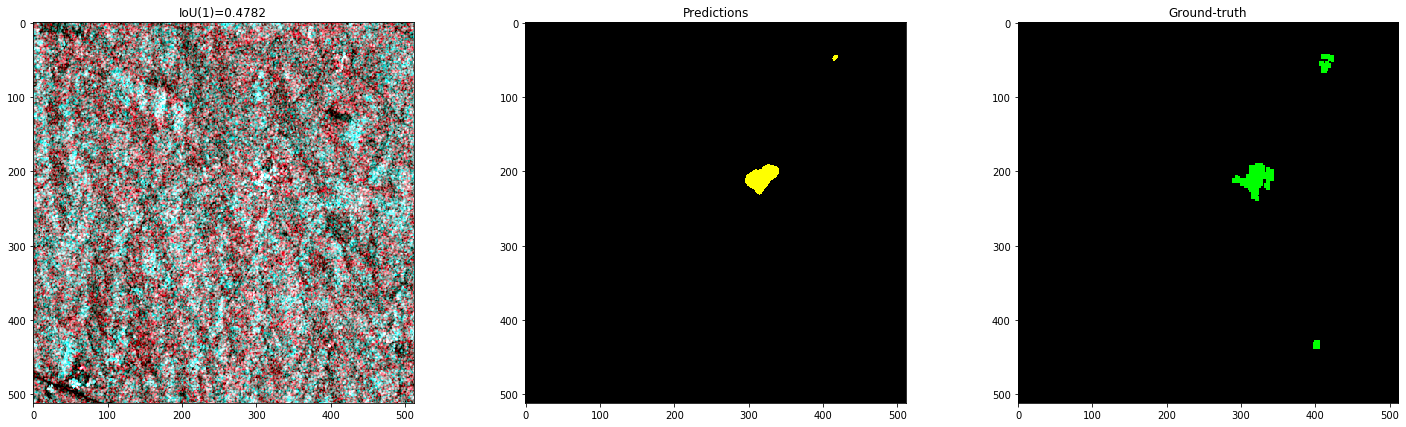

In [24]:
display_preds(y_preds1, y, dp['image'])

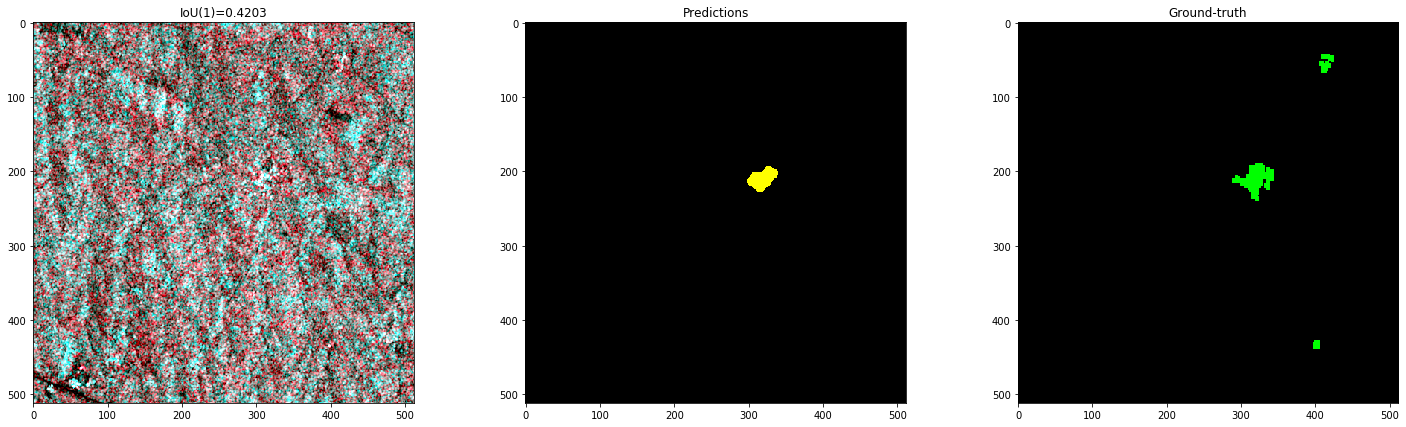

In [25]:
display_preds(y_preds3, y, dp['image'])

In [26]:
# display_preds(y_preds2, y, dp['image'])

In [27]:
# display_preds(y_preds2, y, dp['image'])

Check on validation datapoint

In [33]:
i = 1020
dp = val_ds[i]

In [34]:
xy = val_transforms(**dp)
x = xy['image'].to(device).unsqueeze(0)
y = xy['mask'].to(device).unsqueeze(0)

In [35]:
with torch.no_grad():
    
#     y_preds = compute_preds(model, x)
    y_preds1 = model(x)
#     y_preds2 = compute_preds(model2, x)
    y_preds3 = model2(x)

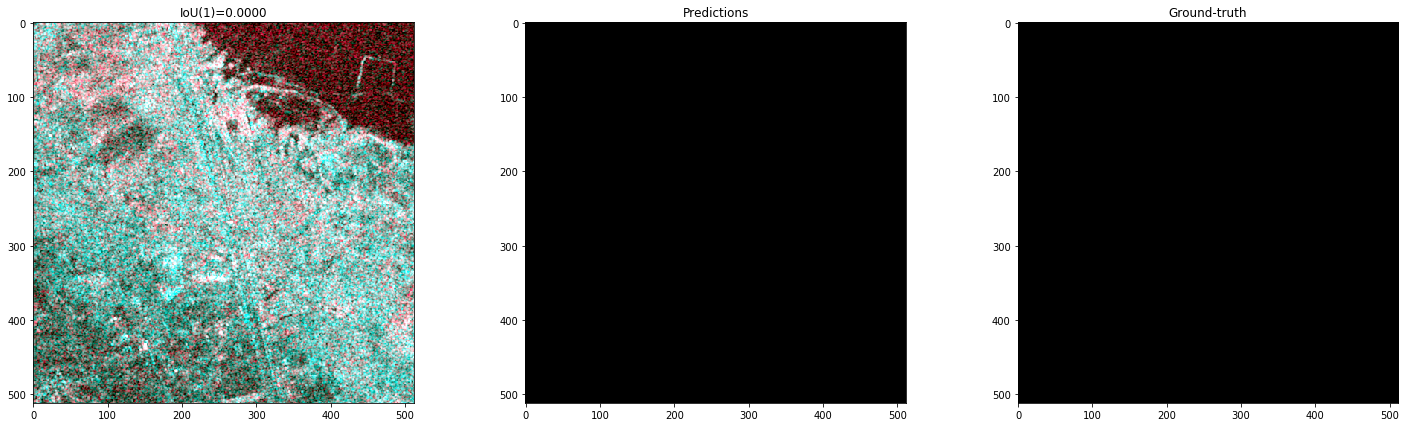

In [36]:
display_preds(y_preds1, y, dp['image'])

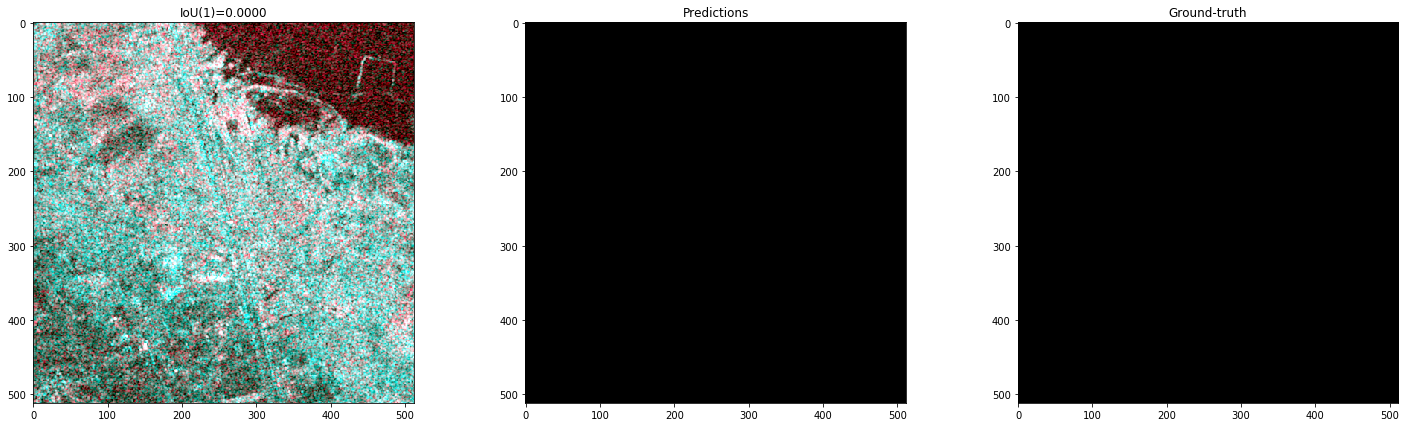

In [37]:
display_preds(y_preds3, y, dp['image'])

In [39]:
# display_preds(y_preds2, y, dp['image'])

In [40]:
# display_preds(y_preds3, y, dp['image'])

In [38]:
i = 560
dp = val_ds[i]

In [39]:
xy = val_transforms(**dp)
x = xy['image'].to(device).unsqueeze(0)
y = xy['mask'].to(device).unsqueeze(0)

In [40]:
with torch.no_grad():
    y_preds = model(x)
    y_preds2 = model2(x)    

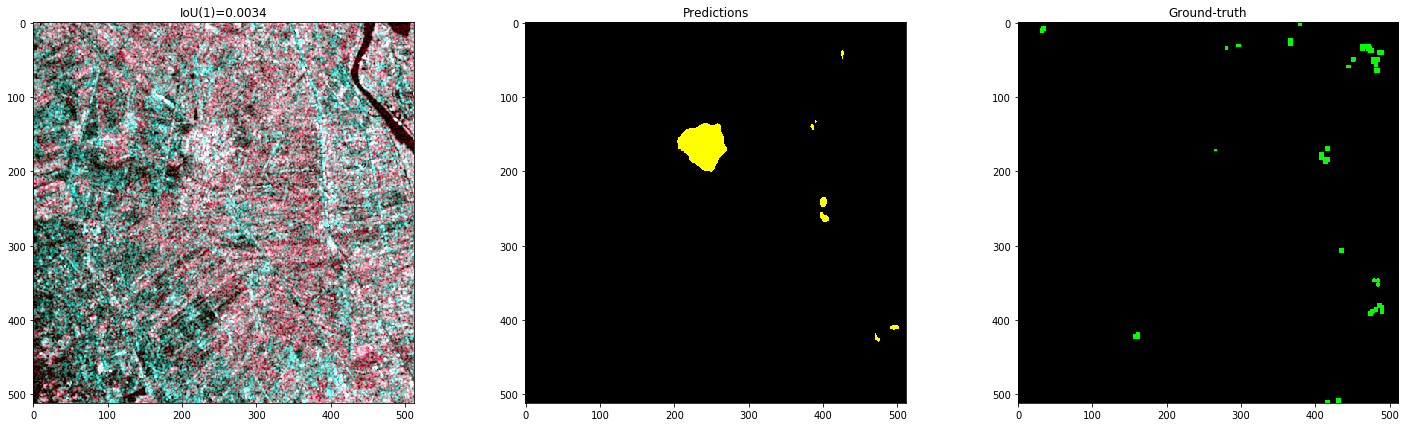

In [41]:
display_preds(y_preds, y, dp['image'])

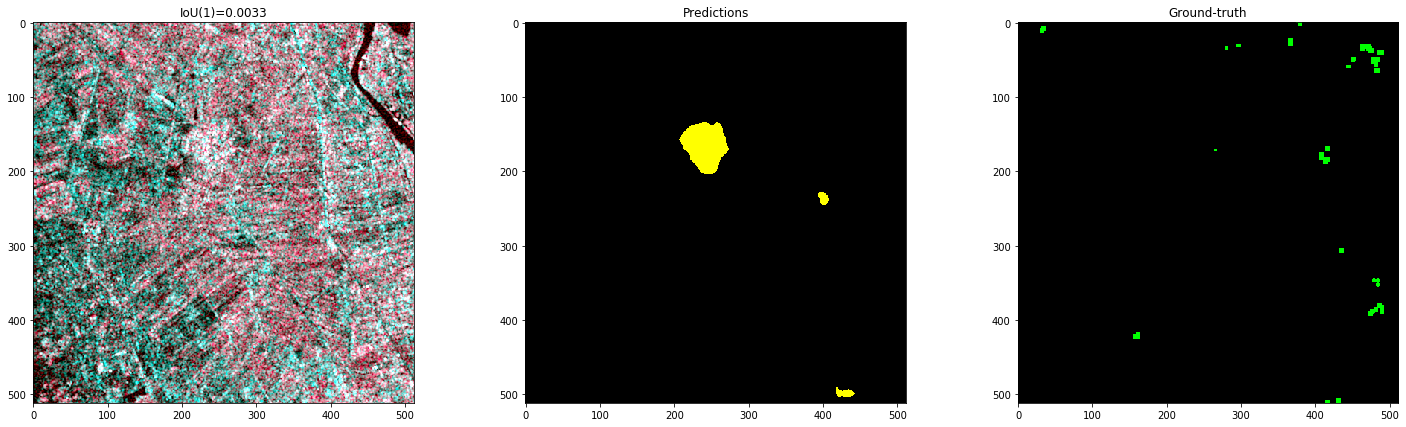

In [42]:
display_preds(y_preds2, y, dp['image'])

In [43]:
i = 1560
dp = val_ds[i]

In [44]:
xy = val_transforms(**dp)
x = xy['image'].to(device).unsqueeze(0)
y = xy['mask'].to(device).unsqueeze(0)

In [47]:
with torch.no_grad():
    y_preds = model(x)
    y_preds2 = model2(x)    

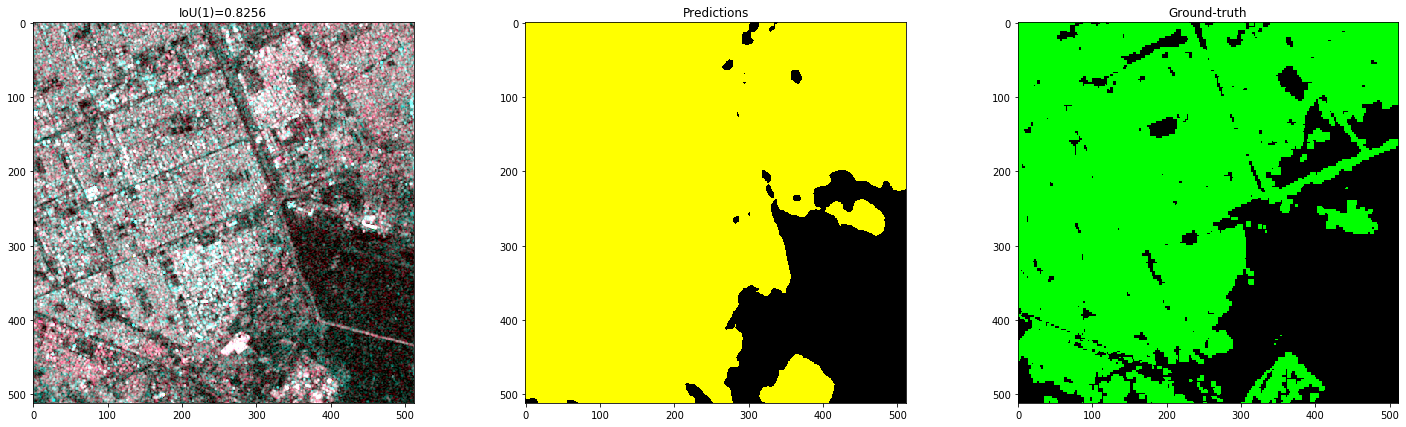

In [46]:
display_preds(y_preds, y, dp['image'])

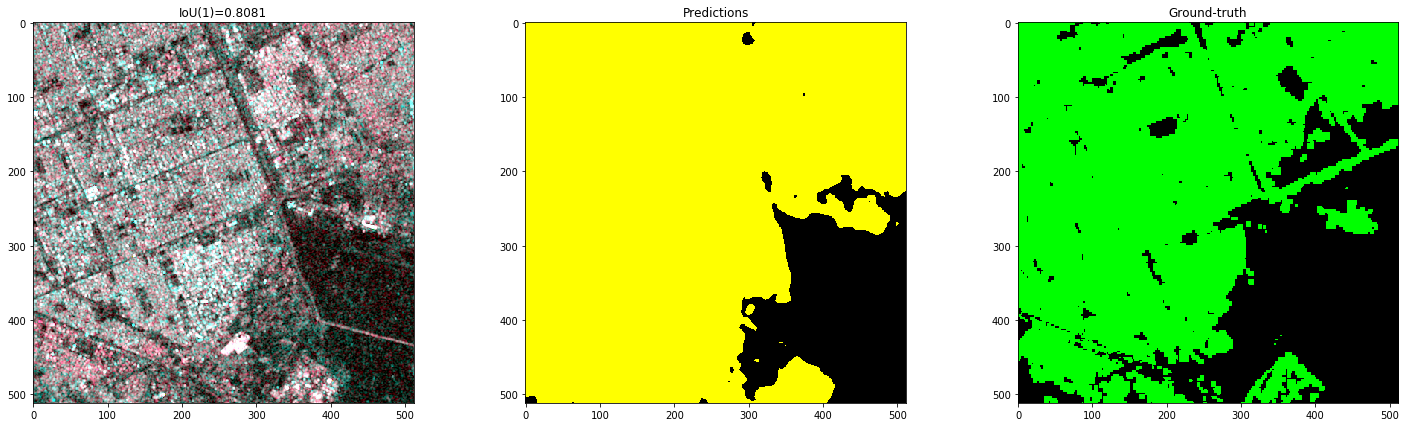

In [48]:
display_preds(y_preds2, y, dp['image'])